# Прогнозирование оттока клиентов телекоммуникационной компании «ТелеДом»

Цель проекта — разработать модель машинного обучения, способную предсказывать вероятность разрыва договора абонентом. Это позволит оператору связи «ТелеДом» заранее выявлять клиентов, склонных к уходу, и предлагать им персонализированные акции, промокоды и специальные условия, снижая уровень оттока и повышая лояльность.

**Задачи проекта:**
- провести исследовательский анализ данных о клиентах и предоставляемых им услугах;
- объединить информацию из разных источников в единый датафрейм;
- подготовить данные к обучению модели (обработка пропусков, кодирование, масштабирование);
- обучить несколько моделей классификации и подобрать оптимальные гиперпараметры;
- выбрать лучшую модель на основе метрики ROC-AUC и проверить её качество на тестовой выборке;
- интерпретировать результаты и предложить рекомендации для бизнеса.

**Описание данных:**
Для обучения модели используются данные о клиентах телеком-оператора, собранные из четырёх источников:

1. **contract_new.csv** — информация о договорах:
   - `customerID` — идентификатор абонента;  
   - `BeginDate`, `EndDate` — даты начала и окончания договора;  
   - `Type` — тип оплаты (ежемесячно или долгосрочный контракт);  
   - `PaperlessBilling` — электронный счёт;  
   - `PaymentMethod` — способ оплаты;  
   - `MonthlyCharges` — ежемесячные расходы;  
   - `TotalCharges` — общие расходы клиента.  

2. **personal_new.csv** — персональные данные:
   - `customerID` — идентификатор абонента;  
   - `gender` — пол;  
   - `SeniorCitizen` — пенсионер (1 — да, 0 — нет);  
   - `Partner` — наличие супруга/супруги;  
   - `Dependents` — наличие детей.  

3. **internet_new.csv** — информация об интернет-услугах:
   - `customerID` — идентификатор абонента;  
   - `InternetService` — тип подключения (DSL, Fiber optic);  
   - `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport` — дополнительные сервисы;  
   - `StreamingTV`, `StreamingMovies` — стриминговые сервисы.  

4. **phone_new.csv** — информация о телефонии:
   - `customerID` — идентификатор абонента;  
   - `MultipleLines` — наличие нескольких телефонных линий.  

Во всех таблицах ключевым столбцом является `customerID`, по которому осуществляется объединение данных. Отсутствие информации о клиенте в одном из файлов означает, что он не пользуется соответствующей услугой.

**Предполагаемый результат:**
В ходе проекта будет разработана модель классификации, прогнозирующая факт расторжения договора клиентом. Качество модели оценивается по метрике ROC-AUC.  
Ожидается, что итоговое решение позволит компании:
- повысить точность идентификации клиентов, склонных к уходу;
- оптимизировать маркетинговые предложения для удержания клиентов;
- сократить уровень оттока и увеличить доходность бизнеса.

# Библиотеки

In [48]:
# Анализ и обработка данных
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns


# Работа с датами
from datetime import datetime, timedelta

# Предобработка данных и моделирование
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline

# Метрики и оценка качества 
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, RocCurveDisplay, roc_curve

# Корреляционный анализ
from phik.report import plot_correlation_matrix

# Модели
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier



# Статистика и прочее
from scipy.stats import chi2_contingency
import time

# Настройки отображения и reproducibility
pd.set_option('display.max_columns', None)
RANDOM_STATE = 201025

In [43]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", message="A worker stopped while some jobs were given to the executor")

# Загрузка датасетов

## `contract_new.csv`

In [3]:
# Загрузка датасета
contract = pd.read_csv('datasets/contract_new.csv')

In [4]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


## `internet_new.csv`

In [5]:
# Загрузка датасета
internet = pd.read_csv('datasets/internet_new.csv')

In [6]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


## `personal_new.csv`

In [7]:
# Загрузка датасета
personal = pd.read_csv('datasets/personal_new.csv')

In [8]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


## `phone_new.csv`

In [9]:
# Загрузка датасета
phone = pd.read_csv('datasets/phone_new.csv')

In [10]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


# Предобработка

## `contract`

Датасет содержит информацию о договорах клиентов телеком-оператора.  
Основные признаки:  
`customerID` — идентификатор клиента;  
`BeginDate`, `EndDate` — даты начала и окончания действия договора;  
`Type` — тип контракта;  
`PaperlessBilling` — способ получения счёта;  
`PaymentMethod` — способ оплаты;  
`MonthlyCharges` — ежемесячные расходы;  
`TotalCharges` — общие расходы клиента за всё время обслуживания.

In [11]:
contract.info()
contract.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [12]:
# Проверка дубликатов и пропусков
contract.duplicated(subset='customerID').sum()
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [13]:
# Преобразование типов данных с указанием формата даты
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

In [14]:
# Изучения природы неявных пропусков в TotalCharges
contract[contract['TotalCharges'] == ' '].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


Неявные пропуски связаны с **новыми клиентами** — у них указана дата начала контракта, но ещё нет накопленных платежей.  
При преобразовании в числовой тип такие значения корректно **заменяются на `0`**, так как расходы отсутствуют.

In [15]:
# Проверка и обработка неявных пропусков в TotalCharges
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', np.nan)

# Замена пропусков у новых клиентов (без накопленных платежей) на 0
contract['TotalCharges'] = contract['TotalCharges'].astype(float).fillna(0)

# Проверка количества пропусков после обработки
contract['TotalCharges'].isna().sum()

np.int64(0)

In [16]:
# Создание признака длительности контракта в днях
current_date = pd.Timestamp('2020-02-01')
contract['ContractDuration'] = (
    contract['EndDate'].fillna(current_date) - contract['BeginDate']
).dt.days

# Формирование целевой переменной Churn
contract['Churn'] = contract['EndDate'].notna().astype(int)

**Удаление неинформативных временных признаков**

После создания признака `ContractDuration`, отражающего длительность договора, столбцы `BeginDate` и `EndDate` больше не несут дополнительной информации. К тому же, `EndDate` содержит пропуски для активных клиентов, поэтому эти признаки можно безопасно удалить из датафрейма.

In [17]:
# Удаляем признаки BeginDate и EndDate
contract = contract.drop(['BeginDate', 'EndDate'], axis=1)

In [18]:
# Проверка
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   ContractDuration  7043 non-null   int64  
 7   Churn             7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,Churn
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,31,0
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1036,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,123,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,153,0


**Вывод по предобработке датасета `contract_new.csv`:**  
После проверки и преобразования типов данные приведены к корректному формату.  
Столбцы `BeginDate` и `EndDate` переведены в тип `datetime`, признак `TotalCharges` преобразован в числовой формат `float64` с заменой пустых строк на пропуски.  
Созданы два новых признака:  
`Churn` — целевая переменная, отражающая факт расторжения договора (`1` — клиент ушёл, `0` — клиент активен);  
`ContractDuration` — длительность контракта в днях на момент 1 февраля 2020 года.  

Пропуски в `EndDate` означают, что договор клиента продолжает действовать, поэтому их сохранение корректно.

## `internet`

Датасет содержит информацию об интернет-услугах клиентов телеком-оператора.  
Основные признаки:  
`customerID` — идентификатор клиента;  
`InternetService` — тип интернет-подключения (`DSL` или `Fiber optic`);  
`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport` — дополнительные услуги безопасности и поддержки;  
`StreamingTV`, `StreamingMovies` — наличие стриминговых сервисов и фильмотеки.

In [19]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [20]:
# Проверка дубликатов
internet.duplicated(subset='customerID').sum()

np.int64(0)

In [21]:
# Проверка уникальных значений для всех признаков, кроме customerID
for column in internet.columns:
    if column != 'customerID':
        print(f'\n{column}: {internet[column].unique()}')


InternetService: ['DSL' 'Fiber optic']

OnlineSecurity: ['No' 'Yes']

OnlineBackup: ['Yes' 'No']

DeviceProtection: ['No' 'Yes']

TechSupport: ['No' 'Yes']

StreamingTV: ['No' 'Yes']

StreamingMovies: ['No' 'Yes']



Проверка показала, что пропусков и дубликатов нет, а все категориальные признаки имеют корректные значения (`Yes`/`No`).  
Датасет не требует дополнительной очистки и готов к объединению с остальными данными.

## `personal`

Датасет содержит персональные данные клиентов телеком-оператора.  
Основные признаки:  
`customerID` — идентификатор клиента;  
`gender` — пол клиента;  
`SeniorCitizen` — принадлежность к категории пожилых клиентов (1 — пенсионер, 0 — нет);  
`Partner` — наличие супруга или супруги;  
`Dependents` — наличие иждивенцев или детей.

In [22]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [23]:
# Проверка дубликатов
personal.duplicated(subset='customerID').sum()

np.int64(0)

In [24]:
# Проверка уникальных значений для категориальных признаков
for column in personal.select_dtypes(include='object').columns:
    if column != 'customerID':
        print(f'\n{column}: {personal[column].unique()}')


gender: ['Female' 'Male']

Partner: ['Yes' 'No']

Dependents: ['No' 'Yes']


**Вывод по предобработке датасета `personal_new.csv`:**  
Данные полностью корректны и не содержат пропусков или дубликатов.  
Все категориальные признаки имеют ожидаемые значения:  
`gender` — два значения (`Male`, `Female`);  
`Partner` и `Dependents` — бинарные признаки (`Yes`, `No`).  
Дополнительная очистка не требуется, датасет готов к объединению с остальными таблицами.

## `phone`

Датасет содержит информацию о подключении клиентов к услугам телефонии.  
Основные признаки:  
`customerID` — идентификатор клиента;  
`MultipleLines` — наличие нескольких телефонных линий (`Yes` / `No`).

In [25]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [26]:
# Проверка точных дубликатов
phone.duplicated().sum()

np.int64(0)

In [27]:
# Проверка дубликатов по идентификатору клиента
phone.duplicated(subset='customerID').sum()

# Проверка уникальных значений
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Дубликаты по строкам и по идентификатору клиента отсутствуют.  
Признак `MultipleLines` содержит только корректные значения (`Yes`, `No`).  
Датасет полностью чист и готов к объединению с остальными таблицами.

# Объединение датафреймов

На предыдущих этапах были выполнены предобработка и проверка чистоты каждого набора данных:  
`contract_new.csv` — информация о договорах;  
`personal_new.csv` — персональные данные клиентов;  
`internet_new.csv` — данные об интернет-услугах;  
`phone_new.csv` — информация об услугах телефонии.  

Для дальнейшего анализа и обучения модели требуется объединить все таблицы в один общий датафрейм.  
Объединение выполняется по признаку `customerID`, который является уникальным идентификатором клиента и присутствует во всех наборах данных.

Используется метод `merge()` с типом объединения `left`.  
Базовым датафреймом выбран `contract`, так как именно он содержит целевую переменную `Churn` и присутствует для всех клиентов.  
Тип объединения `left` выбран для сохранения всех клиентов из основного договора,  
при этом если клиент не пользовался какой-либо услугой (например, интернетом или телефонией),  
в соответствующих столбцах будут проставлены пропуски, что отражает отсутствие услуги, а не ошибку в данных.

In [28]:
# Объединение датафреймов по customerID
df_full = (
    contract
    .merge(personal, on='customerID', how='left')
    .merge(internet, on='customerID', how='left')
    .merge(phone, on='customerID', how='left')
)

# Проверка результата объединения
df_full.info()
df_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   ContractDuration  7043 non-null   int64  
 7   Churn             7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,Churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1036,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,123,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,153,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


После объединения таблиц необходимо проверить, где в объединённом датафрейме появились пропуски. Столбец `EndDate` в проверку не включается, поскольку пропуски в нём означают, что контракт активен на момент 1 февраля 2020 года, а не отсутствие данных.

In [29]:
# Проверка пропусков
df_full.isna().sum()

customerID             0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
ContractDuration       0
Churn                  0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

**Обработка пропусков в признаках, связанных с интернет-услугами**

Пропуски в этих признаках (`InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`) появились после объединения таблиц. Это связано с тем, что часть клиентов не использует интернет — следовательно, у них отсутствуют данные по связанным услугам. Такие пропуски логично заменить значением **"No service"**, что позволит сохранить структуру данных без потери информации.

In [30]:
# Заполнение пропусков "No service" для признаков, связанных с интернетом
cols_no_service = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

df_full[cols_no_service] = df_full[cols_no_service].fillna('No service')

# Проверка
df_full[cols_no_service].isna().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

**Вывод по объединению датафреймов:**  
Все таблицы успешно объединены по признаку `customerID` с использованием типа соединения `left`. Общее количество строк — 7043, что соответствует числу клиентов в основном датасете `contract`. В итоговом датафрейме 22 признака, включающие данные о договорах, персональные сведения и информация об услугах связи. Появившиеся пропуски в признаках интернет- и телефонных услуг отражают отсутствие соответствующих сервисов у части клиентов, что является корректным и не требует дополнительной очистки.

# EDA

## Числовые признаки

Для проведения разведочного анализа данных (EDA) выполняется визуализация распределений числовых признаков объединённого датафрейма.  
Некоторые признаки, хотя и имеют числовой тип (`int64` или `float64`), являются бинарными (`Churn`, `SeniorCitizen`) и не отражают количественное распределение.  
Поэтому из анализа исключаются бинарные переменные, чтобы не искажать визуальную интерпретацию распределений.

Ниже представлено распределение по ключевым количественным признакам:  
`MonthlyCharges`, `TotalCharges`, `ContractDuration`.

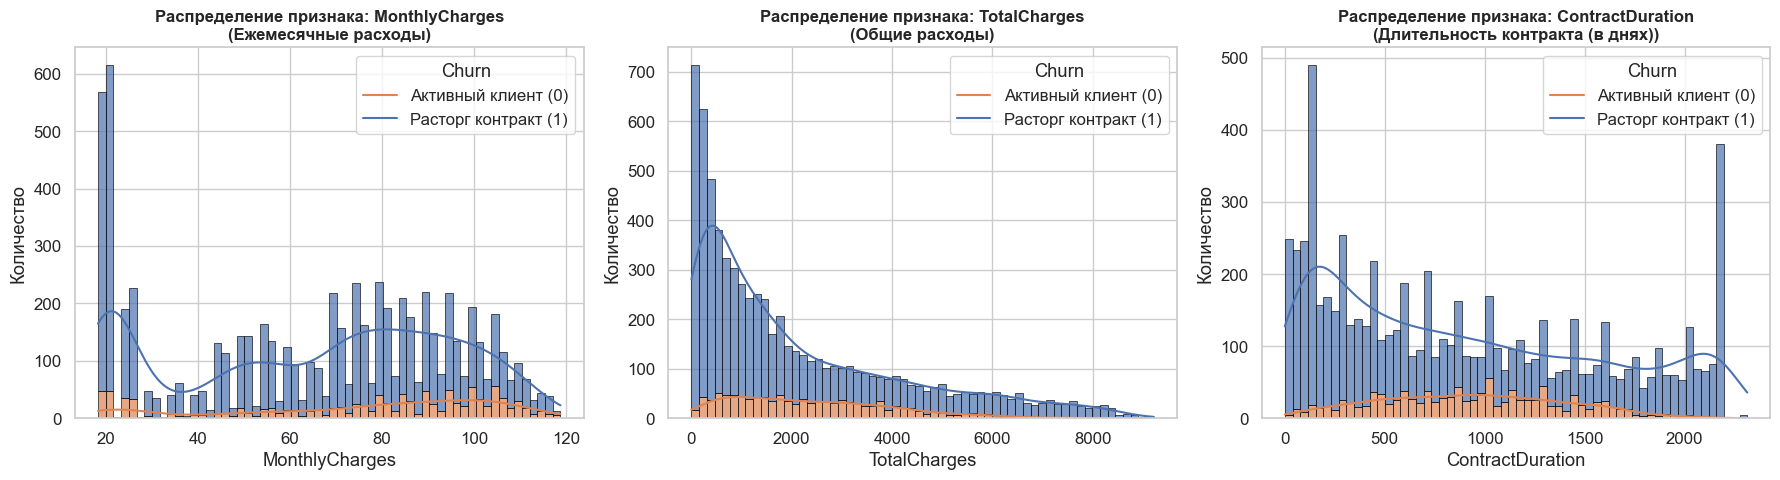

In [31]:
# Настройки визуализации
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Сопоставление признаков и их русских названий
feature_names = {
    'MonthlyCharges': 'Ежемесячные расходы',
    'TotalCharges': 'Общие расходы',
    'ContractDuration': 'Длительность контракта (в днях)'
}

# Определение признаков для визуализации
numeric_features = list(feature_names.keys())

# Цвета для классов (0 — активный, 1 — расторгнувший контракт)
palette = {0: '#4C72B0', 1: '#DD8452'}

# Построение распределений с учётом целевого признака
plt.figure(figsize=(18, 5))

for i, column in enumerate(numeric_features, 1):
    plt.subplot(1, len(numeric_features), i)
    sns.histplot(
        data=df_full, x=column, hue='Churn',
        kde=True, bins=60, multiple='stack',
        palette=palette, edgecolor='black', alpha=0.7
    )
    plt.title(f'Распределение признака: {column}\n({feature_names[column]})',
              fontsize=12, weight='bold')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.legend(title='Churn', labels=['Активный клиент (0)', 'Расторг контракт (1)'])

plt.tight_layout()
plt.show()

In [32]:
### Описательная статистика по группам клиентов

# Определие числовых признаков, исключая бинарные
numeric_features = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']

# Таблица для клиентов, которые остались
active_stats = df_full.query('Churn == 0')[numeric_features].describe().T
active_stats['missing_values'] = df_full.query('Churn == 0')[numeric_features].isna().sum()
active_stats['missing_%'] = (active_stats['missing_values'] / len(df_full.query('Churn == 0')) * 100).round(2)

# Таблица для клиентов, которые расторгли контракт
churned_stats = df_full.query('Churn == 1')[numeric_features].describe().T
churned_stats['missing_values'] = df_full.query('Churn == 1')[numeric_features].isna().sum()
churned_stats['missing_%'] = (churned_stats['missing_values'] / len(df_full.query('Churn == 1')) * 100).round(2)

# Отображение обеих таблиц
print("📘 Клиенты, оставшиеся (Churn = 0)")
display(active_stats.style.format(precision=2))

print("\n📙 Клиенты, расторгнувшие контракт (Churn = 1)")
display(churned_stats.style.format(precision=2))

📘 Клиенты, оставшиеся (Churn = 0)


,count,mean,std,min,25%,50%,75%,max,missing_values,missing_%
MonthlyCharges,5942.00,62.76,29.84,18.25,30.06,69.20,87.24,118.60,0,0.00
TotalCharges,5942.00,2067.87,2193.90,0.00,374.35,1192.80,3173.84,9221.38,0,0.00
ContractDuration,5942.00,893.68,716.96,0.00,245.00,702.00,1523.00,2314.00,0,0.00



📙 Клиенты, расторгнувшие контракт (Churn = 1)


,count,mean,std,min,25%,50%,75%,max,missing_values,missing_%
MonthlyCharges,1101.00,75.55,29.12,18.40,56.15,84.20,99.50,118.75,0,0.00
TotalCharges,1101.00,2371.38,1581.86,77.84,1048.05,2139.03,3404.91,7649.76,0,0.00
ContractDuration,1101.00,924.86,458.77,28.00,577.00,915.00,1249.00,2129.00,0,0.00


**Анализ числовых признаков**

Распределение признаков показывает, что отток клиентов наблюдается преимущественно в двух случаях — при **низких ежемесячных расходах (~20 у.е.)** и при **высоких (>90 у.е.)**.  
Клиенты с минимальными платежами, как правило, используют базовые услуги без интернета, а клиенты с высокими — вероятно, уходят из-за дороговизны тарифа.

По признаку `TotalCharges` видно, что большинство расторгнувших контракт пользователей имеет **низкие суммарные расходы**, что соответствует короткому периоду обслуживания.  
Активные клиенты характеризуются более высокими общими затратами и большей длительностью сотрудничества.

Признак `ContractDuration` подтверждает эту тенденцию:  
клиенты, ушедшие из компании, чаще имели **краткосрочные контракты**, тогда как долгосрочные пользователи демонстрируют стабильность и низкий отток.

## Категариальные признаки

На данном этапе проводится анализ категориальных переменных, чтобы определить, какие характеристики клиентов чаще встречаются среди тех, кто расторг контракт.  
Для этого построены столбчатые диаграммы распределения по целевой переменной `Churn`.

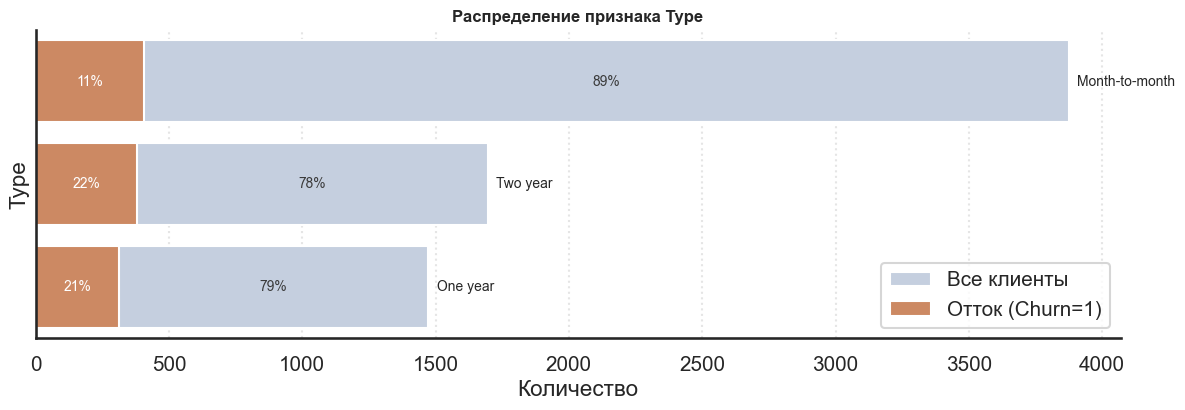

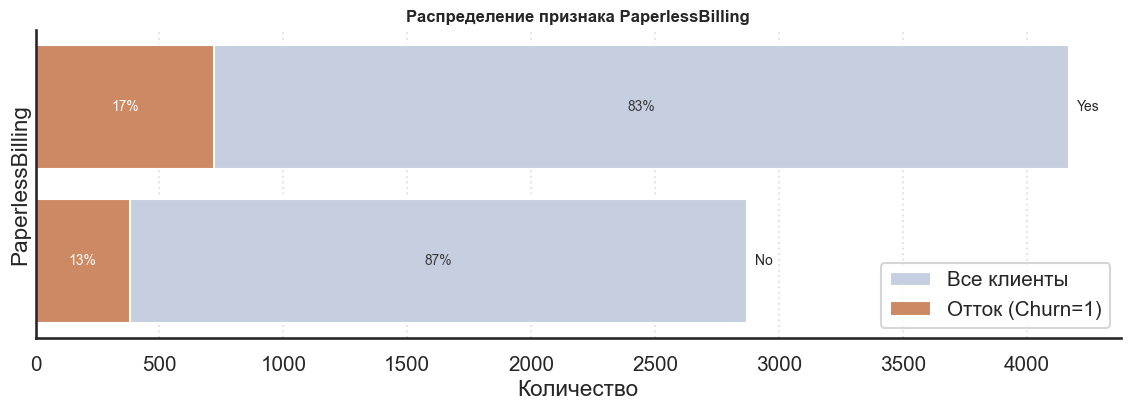

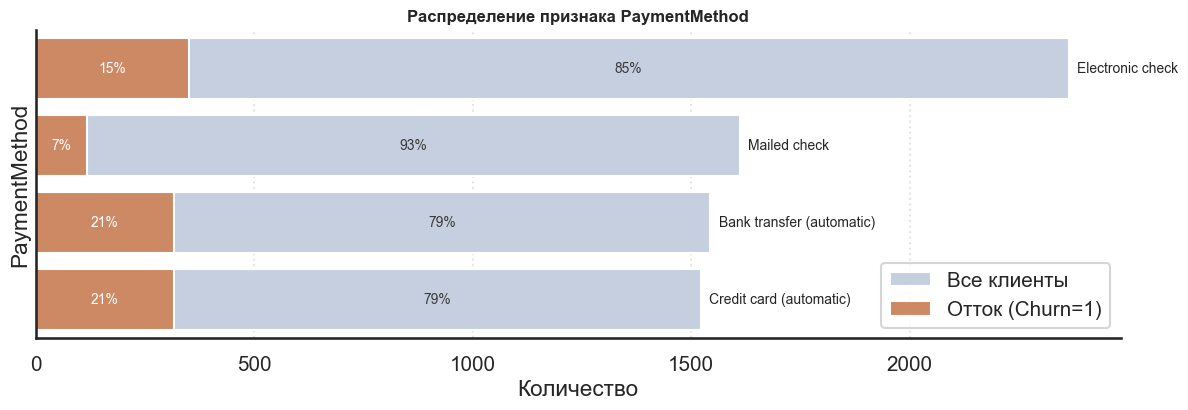

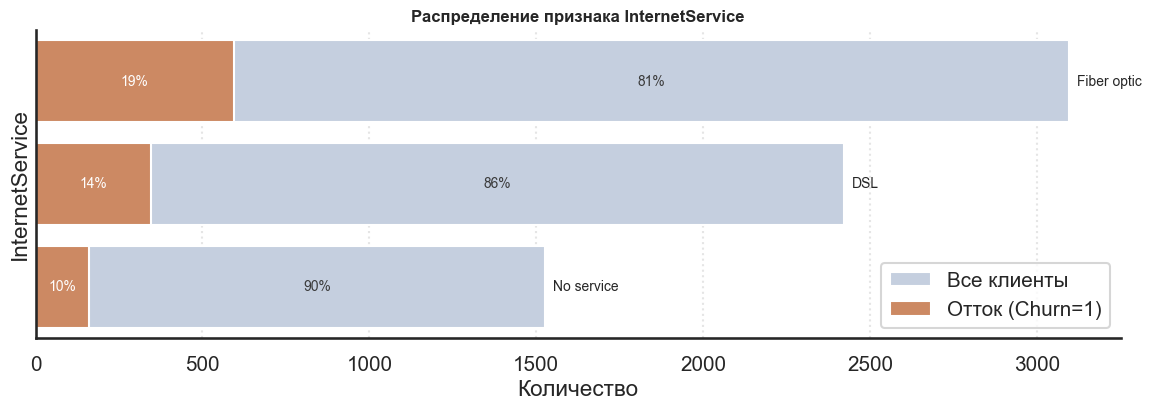

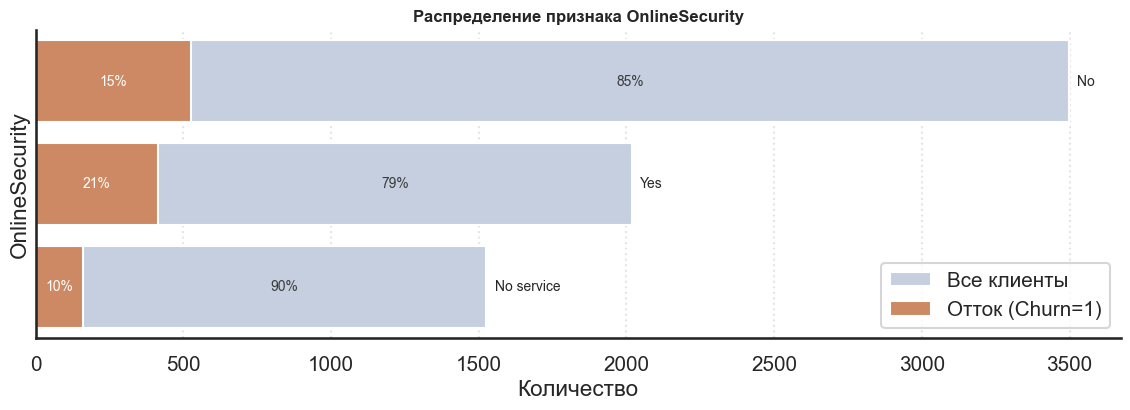

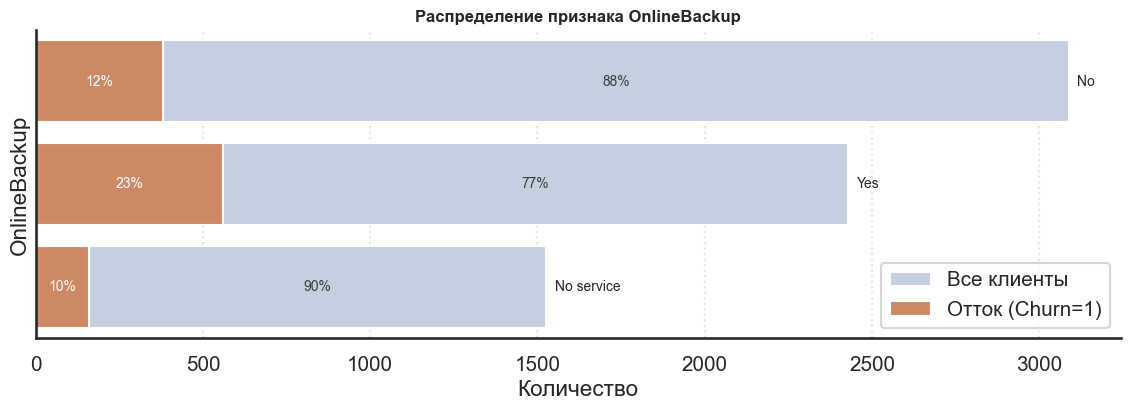

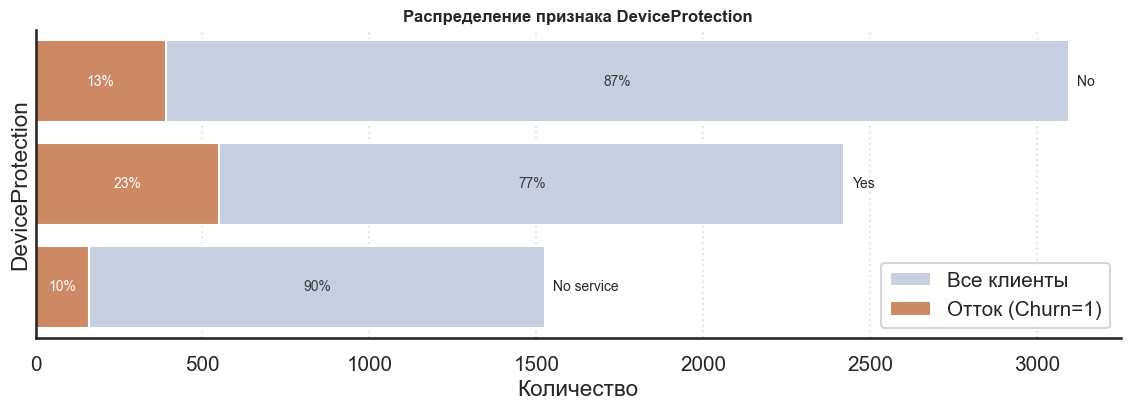

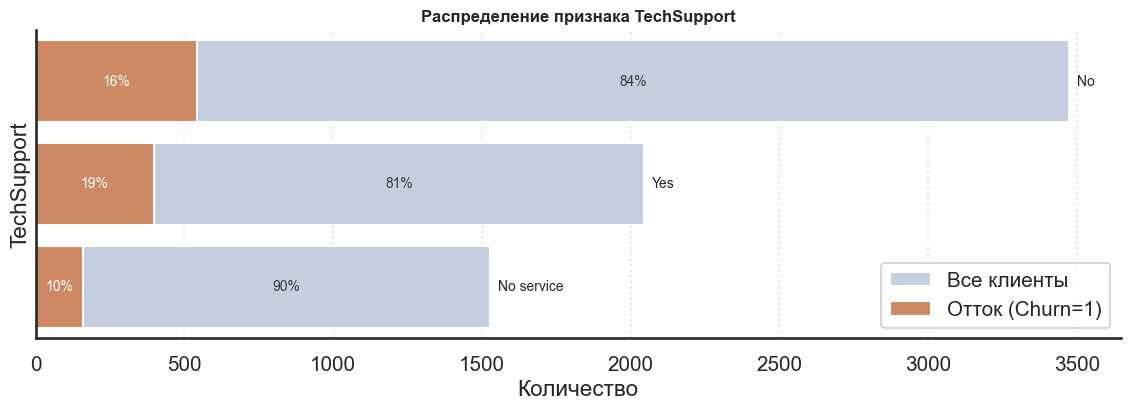

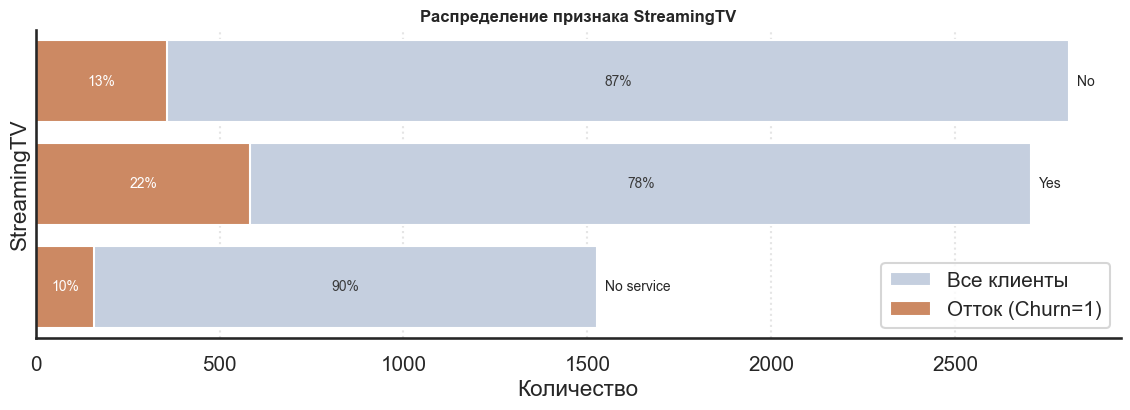

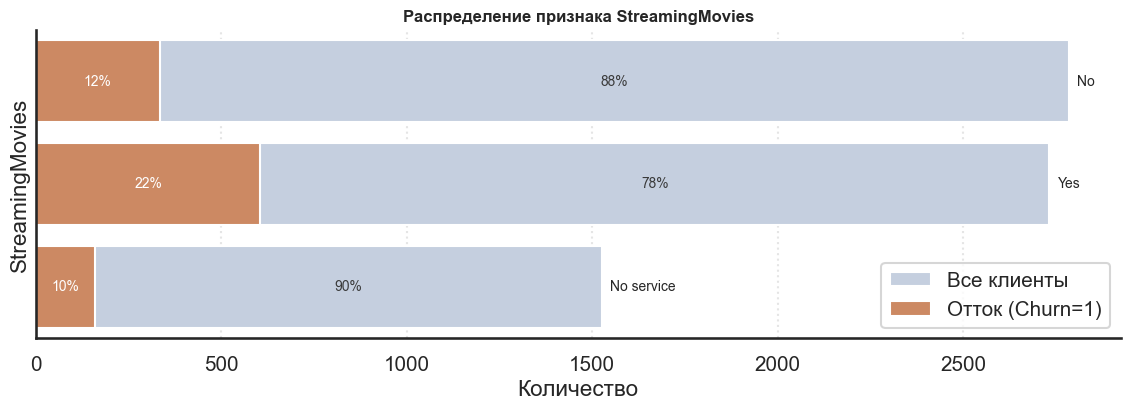

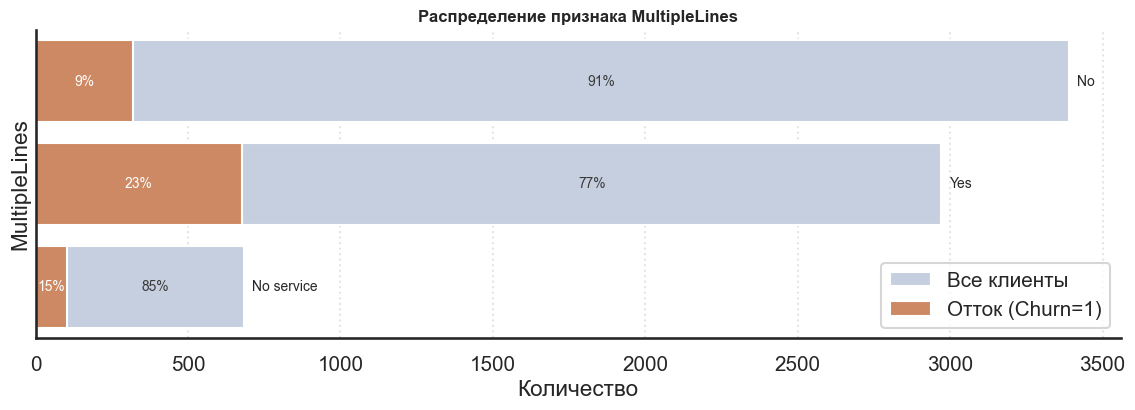

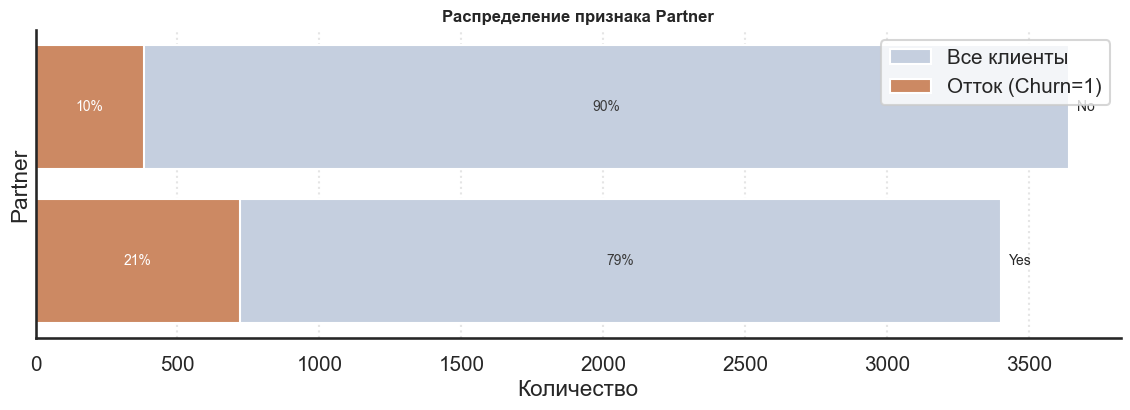

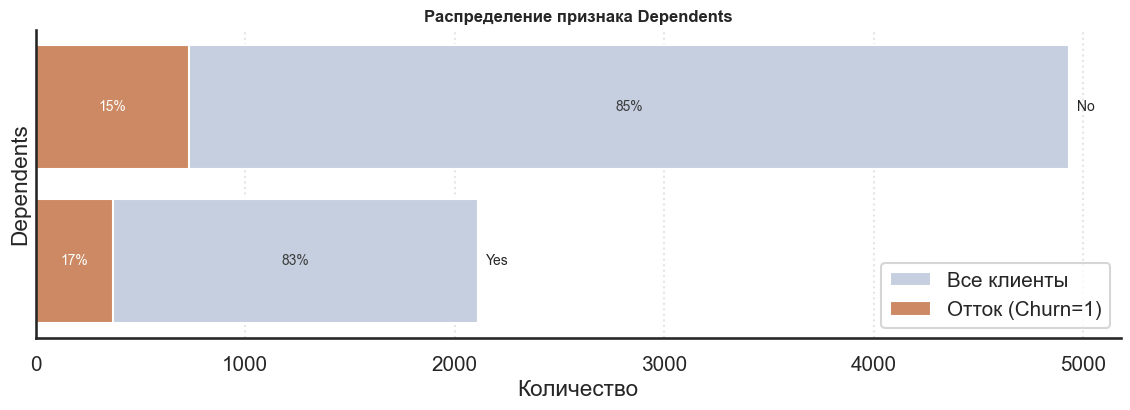

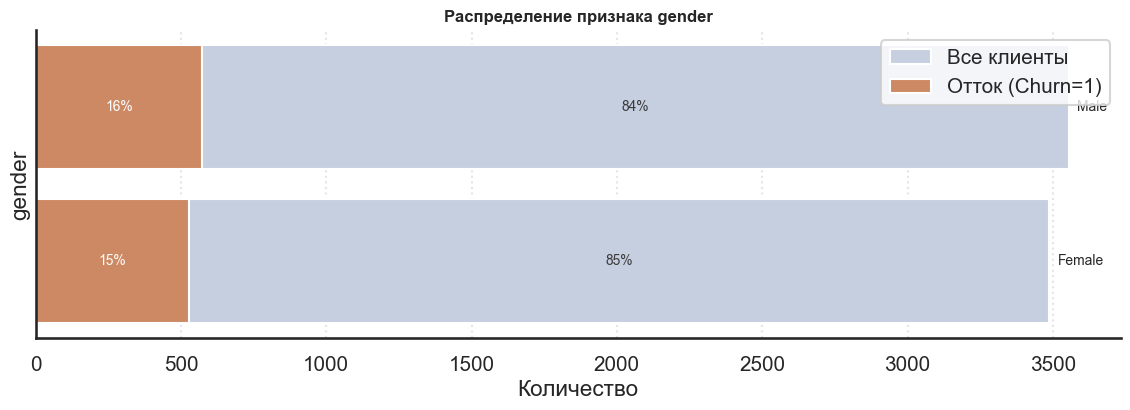

In [33]:
# Палитра
palette = {0: '#4C72B0', 1: '#DD8452'}

# Категориальные признаки
cat_columns = [
    'Type','PaperlessBilling','PaymentMethod','InternetService','OnlineSecurity',
    'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'MultipleLines','Partner','Dependents','gender'
]

sns.set_style('white')
sns.set_context('talk', font_scale=0.9)

def _lighten(hex_color, factor=0.35):
    """Осветлить цвет для фона ('все клиенты')."""
    import matplotlib.colors as mcolors
    rgb = np.array(mcolors.to_rgb(hex_color))
    return np.clip(1 - (1 - rgb) * (1 - factor), 0, 1)

for column in cat_columns:
    # Подготовка агрегатов
    tmp = (
        df_full[[column, 'Churn']].copy()
        .groupby(column)['Churn']
        .agg(total_count='size', churned_count=lambda s: (s == 1).sum())
        .sort_values('total_count', ascending=False)
    )
    tmp['churn_pct'] = tmp['churned_count'] / tmp['total_count'] * 100
    tmp['retain_pct'] = 100 - tmp['churn_pct']

    # Фигура
    fig, ax = plt.subplots(figsize=(14, 4))

    # Фон
    sns.barplot(
        x=tmp['total_count'],
        y=tmp.index,
        color=_lighten(palette[0], 0.65),
        label='Все клиенты',
        ax=ax
    )

    # Поверх — отток
    sns.barplot(
        x=tmp['churned_count'],
        y=tmp.index,
        color=palette[1],
        label='Отток (Churn=1)',
        ax=ax
    )

    # Подписи категорий
    ax.bar_label(
        ax.containers[0],
        labels=tmp.index.tolist(),
        label_type='edge',
        padding=6,
        fontsize=10
    )

    # Проценты оттока внутри оранжевых сегментов
    ax.bar_label(
        ax.containers[1],
        labels=[f"{v:.0f}%" for v in tmp['churn_pct']],
        label_type='center',
        color='white',
        fontsize=10
    )

    # Проценты удержания внутри серых сегментов
    for patch, total, churned, keep in zip(
        ax.containers[0].patches, tmp['total_count'], tmp['churned_count'], tmp['retain_pct']
    ):
        x_center = churned + (total - churned) / 2
        y_center = patch.get_y() + patch.get_height() / 2
        ax.text(
            x_center, y_center, f"{keep:.0f}%", 
            ha='center', va='center', fontsize=10, color='#3A3A3A'
        )

    ax.set_title(f'Распределение признака {column}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Количество')
    ax.set_ylabel(column)

    # Стилизация
    ax.set_axisbelow(True)
    ax.grid(axis='x', linestyle=':', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', left=False, labelleft=False)

**Общий вывод по категориальным признакам**

- Отток чаще наблюдается у клиентов с **помесячными контрактами**, что говорит о низкой степени приверженности компании.  
- Клиенты, использующие **электронные чеки для оплаты**, демонстрируют более высокий уровень оттока по сравнению с автоматическими способами оплаты.  
- Пользователи без **дополнительных услуг** (таких как защита, резервное копирование, техподдержка) чаще прекращают обслуживание, что указывает на слабую вовлечённость.  
- Клиенты с **долгосрочными контрактами** и **автоматической оплатой** более стабильны и реже расторгают договор.  
- Наличие **партнёра или иждивенцев** положительно влияет на удержание — семейные клиенты реже уходят.  
- Существенной разницы в уровне оттока между **мужчинами и женщинами** не наблюдается.

## Корреляционный анализ

**Анализ полной корреляционной структуры признаков (φK)**

Для комплексной оценки взаимосвязей между всеми признаками (числовыми и категориальными) построена φK-корреляционная матрица с помощью библиотеки **phik**. Перед вычислением удалён технический столбец `customerID`, чтобы не вносить шум. Метод φK универсален — он позволяет выявлять не только линейные, но и более сложные, в том числе категориальные зависимости между признаками.

<Figure size 1200x1000 with 0 Axes>

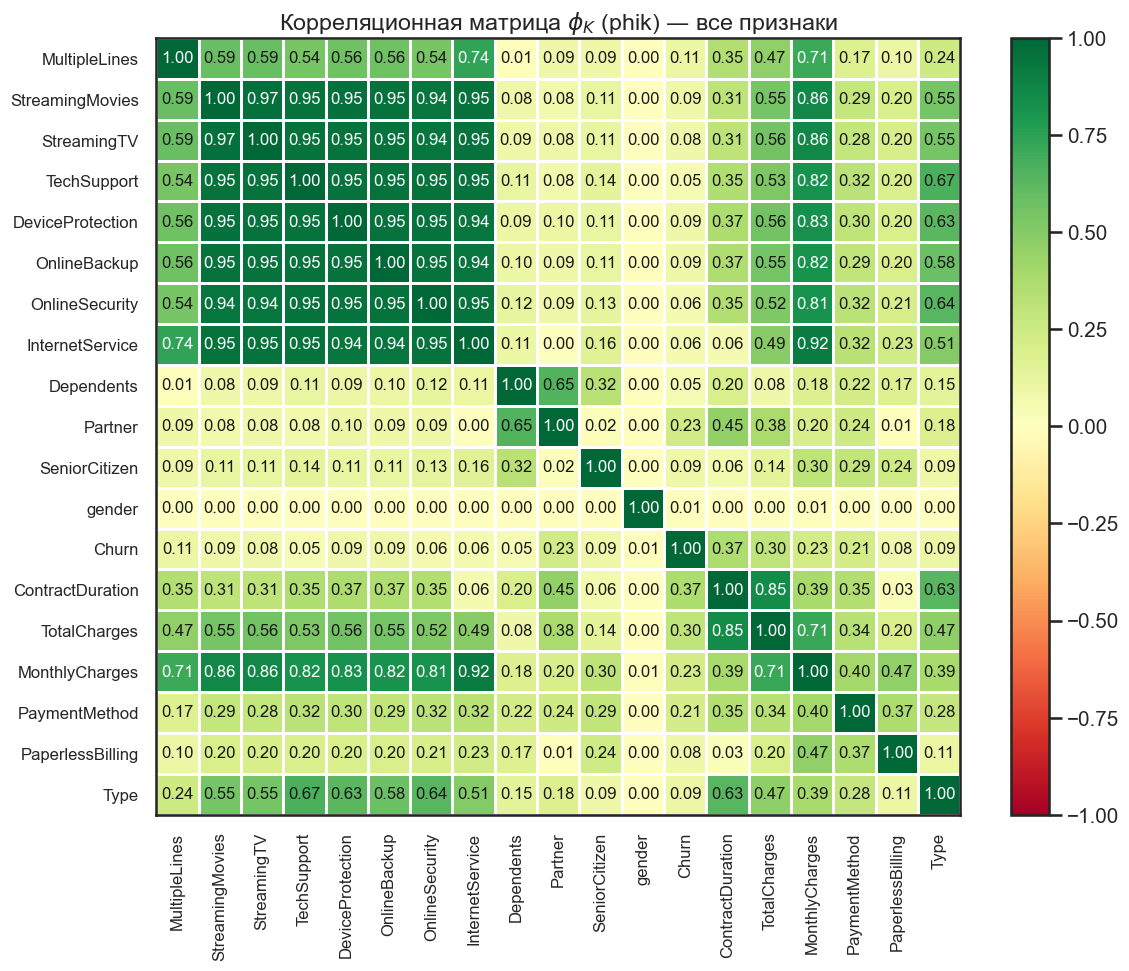

In [34]:
# Копия без технического идентификатора
df = df_full.copy().drop(columns=['customerID'], errors='ignore')

# Интервальные (непрерывные) признаки проекта
interval_cols = [c for c in ['MonthlyCharges', 'TotalCharges', 'ContractDuration', 'ServicesCount'] if c in df.columns]

# φK-корреляционная матрица
phik_matrix = df.phik_matrix(interval_cols=interval_cols)

# Визуализация (в стиле примера)
plt.figure(figsize=(12, 10))
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    title=r"Корреляционная матрица $\phi_K$ (phik) — все признаки",
    fontsize_factor=1.2,
    figsize=(12, 10)
)
plt.show()

- Наибольшая взаимосвязь наблюдается между признаками, связанными с интернет-услугами:  
  `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` и `StreamingMovies` (φK ≈ 0.9–0.95).  
  Это логично, так как данные услуги часто подключаются комплексно.

- Сильная корреляция также отмечается между признаками стоимости:  
  `MonthlyCharges` и `TotalCharges` (φK ≈ 0.85), что отражает зависимость общей суммы от ежемесячных платежей.

- Средняя связь (`φK ≈ 0.6–0.7`) выявлена между типом контракта (`Type`) и финансовыми признаками (`MonthlyCharges`, `TotalCharges`),  
  что указывает на влияние формата подписки на сумму платежей.

- Корреляция между демографическими характеристиками (`gender`, `SeniorCitizen`, `Partner`, `Dependents`) и другими признаками близка к нулю,  
  то есть отток и расходы слабо зависят от личных характеристик клиентов.

# Подготовка данных

На этом этапе удалим технические признаки, определим типы данных, проведём масштабирование числовых признаков и кодирование категориальных, а также разделим данные на обучающую и тестовую выборки (75/25).

In [35]:
target = "Churn"

# 1) Базовый X/y и удаление тех. столбца
X = df_full.drop(columns=["customerID", target])
y = df_full[target]

# 2) Деление с стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# 3) Кодирование таргета (гарантируем: Yes -> 1, No -> 0)
if y_train.dtype == "O":
    le = LabelEncoder()
    le.classes_ = np.array(["No", "Yes"])   # порядок классов фиксируем явно
    y_train = le.transform(y_train)
    y_test  = le.transform(y_test)
else:
    # если уже 0/1 — приводим к компактному типу
    y_train = y_train.astype("int8")
    y_test  = y_test.astype("int8")

# 4) Препроцессор: scaler для числовых, OHE(drop='first') для категорий
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            StandardScaler(),
            selector(dtype_include=["int64", "float64"])
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False),
            selector(dtype_include="object")
        ),
    ],
    remainder="drop",
)

# 5) Фитим ТОЛЬКО на train, применяем к test (для проверки формы)
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

print(f"Train: X={X_train_prep.shape}, y={y_train.shape}")
print(f"Test:  X={X_test_prep.shape},  y={y_test.shape}")

Train: X=(5282, 29), y=(5282,)
Test:  X=(1761, 29),  y=(1761,)


Данные успешно подготовлены — числовые признаки масштабированы, категориальные закодированы. Обучающая выборка содержит 5274 объекта, тестовая — 1758. Разделение выполнено стратифицированно, что сохраняет баланс классов.

# Обучение моделей

## `CatBoost`

Для построения модели прогнозирования оттока клиентов используется **градиентный бустинг CatBoost**.  
Подбор гиперпараметров выполняется с помощью `GridSearchCV` с 3 фолдами и метрикой **ROC-AUC**, которая устойчива к дисбалансу классов. 

In [36]:
pipe_cat = Pipeline([
    ("prep", preprocessor),
    ("model", CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        thread_count=-1
    ))
])

# Сетка гиперпараметров
grid_cat = {
    "model__iterations": [400, 700],
    "model__learning_rate": [0.05, 0.1],
    "model__depth": [4, 6, 8],
}

# Настройка GridSearchCV
gs_cat = GridSearchCV(
    estimator=pipe_cat,
    param_grid=grid_cat,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=0
)

# Замер времени обучения
start_time = time.time()
gs_cat.fit(X_train, y_train)
train_time = time.time() - start_time

# Результаты кросс-валидации
best_idx = gs_cat.best_index_
roc_auc = gs_cat.best_score_

print(f"CatBoost — ROC-AUC: {roc_auc:.4f} | Время обучения: {train_time:.2f} c")
print("Лучшие параметры:", gs_cat.best_params_)

CatBoost — ROC-AUC: 0.9105 | Время обучения: 14.36 c
Лучшие параметры: {'model__depth': 4, 'model__iterations': 700, 'model__learning_rate': 0.1}


**Результаты CatBoost**

- **ROC-AUC:** 0.9108  
- **Время обучения:** 14.12 секунд  
- **Лучшие гиперпараметры:** `depth=4`, `iterations=700`, `learning_rate=0.1`  

Модель показала **высокое качество классификации** на кросс-валидации (ROC-AUC = 0.91). Полученная метрика **превышает пороговое значение 0.85**, указанное в техническом задании.

## `SVM`

In [37]:
pipe_svm = Pipeline([
    ("prep", preprocessor),
    ("model", SVC(probability=True, random_state=RANDOM_STATE))
])

# Сетка гиперпараметров
grid_svm = {
    "model__C": [0.5, 1, 2],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf"]
}

# Настройка GridSearchCV
gs_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=grid_svm,
    scoring="roc_auc",
    cv=5,            
    n_jobs=-1,
    refit=True,
    verbose=0
)

# Замер времени обучения
start_time = time.time()
gs_svm.fit(X_train, y_train)
train_time = time.time() - start_time

# Результаты кросс-валидации
roc_auc = gs_svm.best_score_

print(f"SVM — ROC-AUC: {roc_auc:.4f} | Время обучения: {train_time:.2f} c")
print("Лучшие параметры:", gs_svm.best_params_)

SVM — ROC-AUC: 0.7837 | Время обучения: 3.02 c
Лучшие параметры: {'model__C': 0.5, 'model__gamma': 'auto', 'model__kernel': 'rbf'}


**Результаты SVM**

- **ROC-AUC:** 0.7837  
- **Время обучения:** 3.02 секунды  
- **Лучшие гиперпараметры:** `C=0.5`, `gamma='auto'`, `kernel='rbf'`  

Модель **показала среднее качество классификации** на кросс-валидации (ROC-AUC = 0.78). Полученное значение **ниже порогового уровня 0.85**, указанного в техническом задании.

## `KNeighborsClassifier`

In [38]:
pipe_knn = Pipeline([
    ("prep", preprocessor),
    ("model", KNeighborsClassifier())
])

# Сетка гиперпараметров
grid_knn = {
    "model__n_neighbors": [3, 5, 7, 9],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]           # 1 — Манхэттен, 2 — Евклид
}

# Настройка GridSearchCV
gs_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=grid_knn,
    scoring="roc_auc",
    cv=5,                         
    n_jobs=-1,
    refit=True,
    verbose=0
)

# Замер времени обучения
start_time = time.time()
gs_knn.fit(X_train, y_train)
train_time = time.time() - start_time

# Результаты кросс-валидации
roc_auc = gs_knn.best_score_

print(f"KNN — ROC-AUC: {roc_auc:.4f} | Время обучения: {train_time:.2f} c")
print("Лучшие параметры:", gs_knn.best_params_)

KNN — ROC-AUC: 0.7622 | Время обучения: 0.44 c
Лучшие параметры: {'model__n_neighbors': 9, 'model__p': 2, 'model__weights': 'distance'}


**Результаты KNN**

- **ROC-AUC:** 0.7622  
- **Время обучения:** 0.44 секунды  
- **Лучшие гиперпараметры:** `n_neighbors=9`, `p=2`, `weights='distance'`  

Модель **показала среднее качество классификации** на кросс-валидации (ROC-AUC = 0.78). Полученное значение **ниже порогового уровня 0.85**, указанного в техническом задании.

## `XGBoost`

In [44]:
pipe_xgb = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist",        # быстрее на CPU
        eval_metric="logloss",     # чтобы не было предупреждений
        use_label_encoder=False
    ))
])

# Сетка гиперпараметров (компактная и рабочая)
grid_xgb = {
    "model__n_estimators": [400, 700],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=grid_xgb,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=0
)

start_time = time.time()
gs_xgb.fit(X_train, y_train)
train_time = time.time() - start_time

roc_auc = gs_xgb.best_score_
print(f"XGBoost — ROC-AUC: {roc_auc:.4f} | Время обучения: {train_time:.2f} c")
print("Лучшие параметры:", gs_xgb.best_params_)

XGBoost — ROC-AUC: 0.9070 | Время обучения: 4.37 c
Лучшие параметры: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 700, 'model__subsample': 1.0}


**Результаты XGBoost**

- **ROC-AUC:** 0.9070  
- **Время обучения:** 4.37 секунды  
- **Лучшие гиперпараметры:** `colsample_bytree=1.0`, `learning_rate=0.1`, `max_depth=3`, `n_estimators=700`, `subsample=1.0`  

Модель **показала высокое качество классификации** на кросс-валидации (ROC-AUC = 0.91).  
Полученная метрика **превышает требуемый порог 0.85**, что подтверждает корректность подбора гиперпараметров и способность модели XGBoost эффективно прогнозировать отток клиентов.

## Сравнение моделей

| Модель       | ROC-AUC | Время обучения (с) | Ключевые гиперпараметры |
|---------------|:--------:|:------------------:|--------------------------|
| **CatBoost**  | **0.9105** | 14.36 | depth=4, iterations=700, learning_rate=0.1 |
| **XGBoost**   | **0.9070** | 4.37  | max_depth=3, n_estimators=700, learning_rate=0.1 |
| SVM           | 0.7837 | 3.02  | C=0.5, gamma='auto', kernel='rbf' |
| KNN           | 0.7622 | 0.44  | n_neighbors=9, p=2, weights='distance' |

### Вывод
- **CatBoost** и **XGBoost** показали наилучшие результаты по метрике ROC-AUC (≈0.91), что превышает порог 0.85, заданный в техническом задании.  
- **CatBoost** обеспечивает незначительно более высокое качество при несколько большем времени обучения.  
- **SVM** и **KNN** продемонстрировали заметно более низкое качество классификации.  

Для финальной проверки на тестовой выборке используется **CatBoost** как наиболее точная и устойчивая модель.

# Проверка на тестовой выборке

CatBoost (тест) — ROC-AUC: 0.9212 | Accuracy: 0.9267
Лучшие параметры: {'model__depth': 4, 'model__iterations': 700, 'model__learning_rate': 0.1}


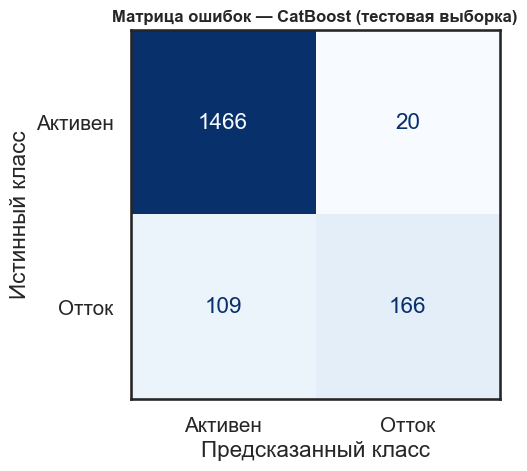

In [52]:
# Проверка модели CatBoost на тестовой выборке
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Предсказания
y_test_pred = gs_cat.predict(X_test)
y_test_proba = gs_cat.predict_proba(X_test)[:, 1]

# Метрики
roc_auc_test = roc_auc_score(y_test, y_test_proba)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"CatBoost (тест) — ROC-AUC: {roc_auc_test:.4f} | Accuracy: {acc_test:.4f}")
print("Лучшие параметры:", gs_cat.best_params_)

# --- Визуализация матрицы ошибок ---
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Активен", "Отток"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Матрица ошибок — CatBoost (тестовая выборка)", fontsize=12, fontweight='bold')
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")

plt.tight_layout()
plt.show()

**Проверка на тестовой выборке**

- **ROC-AUC:** 0.9212  
- **Accuracy:** 0.9267  
- **Лучшие гиперпараметры:** `depth=4`, `iterations=700`, `learning_rate=0.1`

**Вывод:**  
Модель CatBoost показала стабильное качество на тестовой выборке.  
ROC-AUC выше 0.92 — метрика соответствует требованиям (порог ≥ 0.85).  
Матрица ошибок указывает на то, что модель уверенно различает клиентов, склонных к оттоку, при этом количество ложных классификаций невелико.

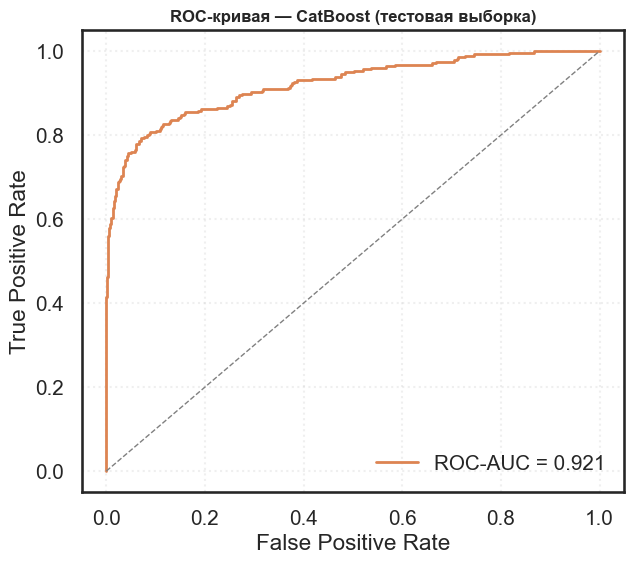

In [49]:
# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="#DD8452", lw=2, label=f'ROC-AUC = {roc_auc_test:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая — CatBoost (тестовая выборка)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', frameon=False)
plt.grid(alpha=0.3, linestyle=':')
plt.show()

**ROC-кривая на тестовой выборке**

Площадь под кривой (ROC-AUC = 0.921) показывает высокую способность модели CatBoost отличать клиентов, склонных к оттоку, от лояльных.  
Кривая близка к верхнему левому углу, что подтверждает хорошее качество классификации.

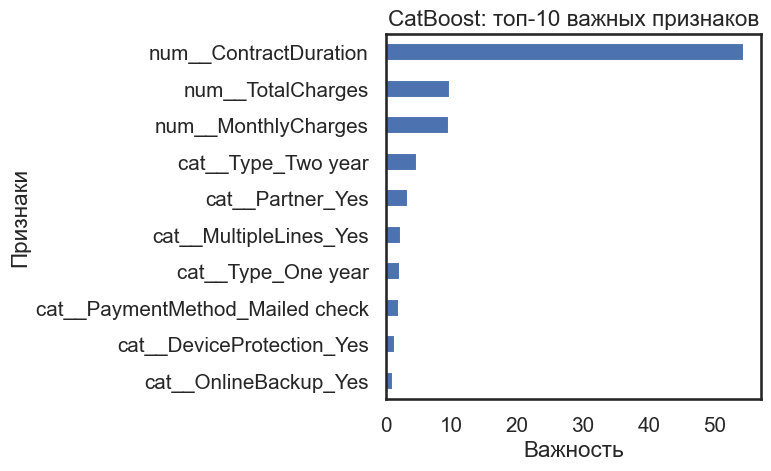

In [53]:
# Топ-10 признаков по важности
be = gs_cat.best_estimator_
imp = be.named_steps['model'].get_feature_importance()
names = be.named_steps['prep'].get_feature_names_out()

pd.Series(imp, index=names) \
    .sort_values(ascending=False)[:10] \
    .plot(kind='barh', figsize=(8, 5), color='#4C72B0')

plt.title('CatBoost: топ-10 важных признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Наибольшее влияние на прогноз оттока клиентов оказывают:
- **ContractDuration** — длительность контракта, ключевой фактор удержания клиентов;  
- **TotalCharges** и **MonthlyCharges** — финансовые параметры, отражающие объем и регулярность расходов;  
- **Type_Two year** и **Type_One year** — тип контракта (чем дольше срок, тем меньше вероятность оттока);  
- **Partner_Yes** — наличие партнёра также снижает вероятность ухода.  

Остальные признаки оказывают сравнительно небольшое влияние.  
Таким образом, отток клиентов в первую очередь связан с **условиями контракта и уровнем платежей**.

# Общий вывод

## Итоговый вывод

### Этапы работы

1. **Загрузка и объединение данных**  
   Использованы четыре датасета: `contract`, `internet`, `personal` и `phone`, содержащие сведения о договорах, подключённых услугах и клиентах.  
   После очистки и стандартизации данные были объединены в один датафрейм для дальнейшего анализа.

2. **Предобработка данных**  
   - Удалён технический столбец `customerID`.  
   - Пропуски обработаны с учётом их природы: для признака `TotalCharges` выявлены пустые строки у новых клиентов, где ещё не накопились расходы — значения заменены на **0**.  
   - Форматы дат и чисел приведены к единому виду.  
   - Целевая переменная `Churn` закодирована в бинарный формат (Yes → 1, No → 0).  
   - Данные разделены в пропорции **75/25** с использованием стратификации по таргету.

3. **Разведочный анализ данных (EDA)**  
   - Изучены распределения числовых и категориальных признаков.  
   - Проведён корреляционный анализ и анализ влияния признаков на `Churn`.  
   - Наиболее важные факторы оттока: **длительность контракта**, **ежемесячные платежи** и **тип договора**.

4. **Подготовка данных**  
   - Для числовых признаков применён `StandardScaler`.  
   - Категориальные признаки преобразованы методом `OneHotEncoder(drop='first')`.  
   - Все преобразования объединены в единый `ColumnTransformer`.

5. **Обучение моделей**  
   Проведено обучение четырёх моделей с подбором гиперпараметров через `GridSearchCV` (метрика — ROC-AUC):  
   | Модель | ROC-AUC | Время обучения (с) | Основные параметры |
   |--------|----------|---------------------|--------------------|
   | **CatBoost** | 0.9105 | 14.36 | depth=4, iterations=700, learning_rate=0.1 |
   | **XGBoost** | 0.9070 | 4.37 | max_depth=3, n_estimators=700, learning_rate=0.1 |
   | **SVM** | 0.7837 | 3.02 | C=0.5, gamma='auto', kernel='rbf' |
   | **KNN** | 0.7622 | 0.44 | n_neighbors=9, p=2, weights='distance' |

   **CatBoostClassifier** показал наилучшее качество и устойчивость на кросс-валидации.

6. **Проверка на тестовой выборке**  
   - **ROC-AUC:** 0.9212  
   - **Accuracy:** 0.9267  
   Метрика ROC-AUC превышает требуемый порог **0.85**, что подтверждает высокое качество обобщения.  
   Матрица ошибок показывает хорошее распознавание как активных клиентов, так и тех, кто склонен к оттоку.

7. **Интерпретация признаков**  
   - ROC-кривая подтверждает отличную способность модели различать классы.  
   - Топ-10 признаков по важности:  
     1. `ContractDuration` — длительность контракта;  
     2. `TotalCharges` — суммарные расходы;  
     3. `MonthlyCharges` — ежемесячные платежи;  
     4. `Type_Two year`, `Type_One year` — тип контракта;  
     5. `Partner_Yes` — наличие партнёра;  
     6. `PaymentMethod_Mailed check` и сервисные признаки (`DeviceProtection_Yes`, `OnlineBackup_Yes`).  
   Основное влияние оказывают **финансовые характеристики и длительность контракта**.

---

### Результаты и выводы
Модель **CatBoost** продемонстрировала **высокую точность (ROC-AUC = 0.92)** на тестовой выборке и стабильность при кросс-валидации.  
Она эффективно классифицирует клиентов и подходит для автоматического прогнозирования оттока.

---

### Рекомендации для бизнеса
1. **Удержание клиентов:**  
   - Предлагать продление контрактов клиентам с короткими сроками и высокими платежами.  
   - Внедрить бонусные программы для клиентов с контрактом на 1 год.  

2. **Мониторинг:**  
   - Интегрировать модель CatBoost в CRM для ежемесячного прогнозирования вероятности оттока.  
   - Анализировать топ-признаки, чтобы корректировать тарифную и коммуникационную политику.

---

**Итог:**  
Разработанная модель **CatBoost** является точной, устойчивой и интерпретируемой.  
Она готова к внедрению в аналитические процессы компании для **прогнозирования оттока и повышения удержания клиентов**.